# Seasonal and biennial ENSO-SIRS models: infections and summary statistics

* Infected fraction over time for standard and +6 month shifted ENSO experiments
* Annual sum of infected and susceptible fraction, ENSO experiments compared to attractor as a percent difference
* Highest infection peak, ENSO experiments compared to attractor as a percent difference
* Compute over years 11-18 (after 1000 years spin-up)

Last modified August 20 2024

In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

#define figure resolution
plt.rcParams['figure.dpi'] = 250

# load data

In [2]:
# parameters for loading the data files

D = 10 # infection period
kick = 0.75 # ENSO kick to R0
R0_base = 3 
R0_amplitude = 0.75

In [3]:
# Load data if needed

# standard R0
R0_over_time = np.load(f'./SIRS_output_final/spinup_1000_R0base{R0_base}_amp{R0_amplitude}_D{D}_R0standard.npy')

# ENSO
ds_Nino = xr.open_dataset(f'./SIRS_output_final/spinup_1000_R0base{R0_base}_amp{R0_amplitude}_kick{kick}_D{D}_1Nino.nc')
ds_Nina = xr.open_dataset(f'./SIRS_output_final/spinup_1000_R0base{R0_base}_amp{R0_amplitude}_kick{kick}_D{D}_1Nina.nc')
ds_NinoNina = xr.open_dataset(f'./SIRS_output_final/spinup_1000_R0base{R0_base}_amp{R0_amplitude}_kick{kick}_D{D}_1Nino1Nina.nc')
ds_NinaNino = xr.open_dataset(f'./SIRS_output_final/spinup_1000_R0base{R0_base}_amp{R0_amplitude}_kick{kick}_D{D}_1Nina1Nino.nc')
ds_3Nino1Nina = xr.open_dataset(f'./SIRS_output_final/spinup_1000_R0base{R0_base}_amp{R0_amplitude}_kick{kick}_D{D}_3Nino1Nina.nc')
ds_3Nina1Nino = xr.open_dataset(f'./SIRS_output_final/spinup_1000_R0base{R0_base}_amp{R0_amplitude}_kick{kick}_D{D}_3Nina1Nino.nc')

In [4]:
# Load data for summer start (6 months later)

# ENSO
ds_Nino_6m = xr.open_dataset(f'./SIRS_output_final/spinup_1000_R0base{R0_base}_amp{R0_amplitude}_kick{kick}_D{D}_1Nino_summerstart.nc')
ds_Nina_6m = xr.open_dataset(f'./SIRS_output_final/spinup_1000_R0base{R0_base}_amp{R0_amplitude}_kick{kick}_D{D}_1Nina_summerstart.nc')
ds_NinoNina_6m = xr.open_dataset(f'./SIRS_output_final/spinup_1000_R0base{R0_base}_amp{R0_amplitude}_kick{kick}_D{D}_1Nino1Nina_summerstart.nc')
ds_NinaNino_6m = xr.open_dataset(f'./SIRS_output_final/spinup_1000_R0base{R0_base}_amp{R0_amplitude}_kick{kick}_D{D}_1Nina1Nino_summerstart.nc')
ds_3Nino1Nina_6m = xr.open_dataset(f'./SIRS_output_final/spinup_1000_R0base{R0_base}_amp{R0_amplitude}_kick{kick}_D{D}_3Nino1Nina_summerstart.nc')
ds_3Nina1Nino_6m = xr.open_dataset(f'./SIRS_output_final/spinup_1000_R0base{R0_base}_amp{R0_amplitude}_kick{kick}_D{D}_3Nina1Nino_summerstart.nc')

In [5]:
# Load attractor
attractor = xr.open_dataset(f'./SIRS_output_final/spinup_1000_R0base{R0_base}_amp{R0_amplitude}_D{D}_standard_attractor.nc')

# align with length of timeseries
n_t = ds_Nino.t.size
attractor = attractor.isel(t=slice(0,n_t))

# Detailed plots with years

In [6]:
# get max peak in each year
def get_peaks(da):
    # input: DataArray with time dimension 't' in days
    # output: DataArray with peak value for each year
    
    nyr = int(np.round((da.t/365).max())) # get number of years in timeseries
    peaks = np.zeros(nyr-1)
    
    for ii in range(nyr-1):
        
        peaks[ii] = da.isel(t=slice(365*ii,365*(ii+1))).max()
        
    peaks_da = xr.DataArray(data=peaks,
                            dims=["year"],
                            coords=dict(year=np.arange(1,nyr)))
    
    return peaks_da

# get sum in each year 
def get_sums(da):
    # input: DataArray with time dimension 't' in days
    # output: DataArray with sum for each year
    
    nyr = int(np.round((da.t/365).max())) # get number of years in timeseries
    sums = np.zeros(nyr-1)
    
    for ii in range(nyr-1):
        
        sums[ii] = da.isel(t=slice(365*ii,365*(ii+1))).sum()
        
    sums_da = xr.DataArray(data=sums, # convert to DataArray
                            dims=["year"],
                            coords=dict(year=np.arange(1,nyr)))
    
    return sums_da

# Max peak

* Find max peak height in each year during time frame
* Subtract maximum peak height of attractor from maximum peak height of ENSO experiment in that time frame

In [7]:
def get_proportions_maxpeak(var,attractor,
                   ds_Nino,ds_Nino_6m,
                        ds_NinaNino,ds_NinaNino_6m,
                        ds_3Nina1Nino,ds_3Nina1Nino_6m,
                           yr1,yr2):
    
    for ii in range(np.size(var)): # susceptibles, infections
        if var[ii] == 'ii':
            clim = get_peaks(attractor['I_att']).sel(year=slice(yr1,yr2)).max() # climatological value
            
        if var[ii] == 'ss':
            clim = get_peaks(attractor['S_att']).sel(year=slice(yr1,yr2)).max() # climatological value
            

        # 1 El Niño
        Ninomaxpeaks = get_peaks(ds_Nino[var[ii]]).sel(year=slice(yr1,yr2))
        # La Niña then El Niño
        NinaNinomaxpeaks = get_peaks(ds_NinaNino[var[ii]]).sel(year=slice(yr1,yr2))
        # 3 La Niña then El Niño
        maxpeaks_3Nina1Nino = get_peaks(ds_3Nina1Nino[var[ii]]).sel(year=slice(yr1,yr2))

        ##### maxpeakmer offset of El Niño #####
        # 1 El Niño
        Ninomaxpeaks_6m = get_peaks(ds_Nino_6m[var[ii]]).sel(year=slice(yr1,yr2))
        # La Niña then El Niño
        NinaNinomaxpeaks_6m = get_peaks(ds_NinaNino_6m[var[ii]]).sel(year=slice(yr1,yr2))
        # 3 La Niña then El Niño
        maxpeaks_3Nina1Nino_6m = get_peaks(ds_3Nina1Nino_6m[var[ii]]).sel(year=slice(yr1,yr2))

        if var[ii] == 'ii':
            ii_maxpeak = [(Ninomaxpeaks.sel(year=slice(yr1,yr2)).max() - clim.max()) / clim.max()*100,
                      (Ninomaxpeaks_6m.sel(year=slice(yr1,yr2)).max() - clim.max()) / clim.max()*100,
                        (NinaNinomaxpeaks.sel(year=slice(yr1,yr2)).max() - clim.max()) / clim.max()*100,
                      (NinaNinomaxpeaks_6m.sel(year=slice(yr1,yr2)).max() - clim.max()) / clim.max()*100,
                      (maxpeaks_3Nina1Nino.sel(year=slice(yr1,yr2)).max() - clim.max()) / clim.max()*100,
                     (maxpeaks_3Nina1Nino_6m.sel(year=slice(yr1,yr2)).max() - clim.max()) / clim.max()*100]

        if var[ii] == 'ss':
            ss_maxpeak = [(Ninomaxpeaks.sel(year=slice(yr1,yr2)).max() - clim.max()) / clim.max()*100,
                      (Ninomaxpeaks_6m.sel(year=slice(yr1,yr2)).max() - clim.max()) / clim.max()*100,
                        (NinaNinomaxpeaks.sel(year=slice(yr1,yr2)).max() - clim.max()) / clim.max()*100,
                      (NinaNinomaxpeaks_6m.sel(year=slice(yr1,yr2)).max() - clim.max()) / clim.max()*100,
                      (maxpeaks_3Nina1Nino.sel(year=slice(yr1,yr2)).max() - clim.max()) / clim.max()*100,
                     (maxpeaks_3Nina1Nino_6m.sel(year=slice(yr1,yr2)).max() - clim.max()) / clim.max()*100]
        
    return ii_maxpeak, ss_maxpeak

# Difference in annual sum (infected, susceptible)
* Get sum in each year over specified time frame (yr1, yr2) for the ENSO experiments
* Subtract sum of attractor, divide by sum of attractor, multiply by 100 to get difference as percent of attractor sum

In [8]:
def get_proportions_sum(var,attractor,
                   ds_Nino,ds_Nino_6m,
                        ds_NinaNino,ds_NinaNino_6m,
                        ds_3Nina1Nino,ds_3Nina1Nino_6m,
                       yr1,yr2):
    # inputs: 
        # var: variable(s) 'ii' or 'ss'
        # attractor 
        # half the ENSO experiments (i.e. La Niña --> El Niño and the 6-month offset, 6 experiments total)
        # yr1, yr2: first and last year of range of climatology & ENSO experiments to compute & compare over
    # outputs:
        # percent difference in annual sum between ENSO experiments and attractor
        
    for ii in range(np.size(var)): # susceptibles, infections
        if var[ii] == 'ii':
            clim = get_sums(attractor['I_att']).sel(year=slice(yr1,yr2)) # climatological value
        if var[ii] == 'ss':
            clim = get_sums(attractor['S_att']).sel(year=slice(yr1,yr2)) # climatological value
            
        ##### standard ENSO experiments #####
        # 1 El Niño
        Ninosums = get_sums(ds_Nino[var[ii]]).sel(year=slice(yr1,yr2))
        # La Niña then El Niño
        NinaNinosums = get_sums(ds_NinaNino[var[ii]]).sel(year=slice(yr1,yr2))
        # 3 La Niña then El Niño
        sums_3Nina1Nino = get_sums(ds_3Nina1Nino[var[ii]]).sel(year=slice(yr1,yr2))

        ##### +6 month offset #####
        # 1 El Niño
        Ninosums_6m = get_sums(ds_Nino_6m[var[ii]]).sel(year=slice(yr1,yr2))
        # La Niña then El Niño
        NinaNinosums_6m = get_sums(ds_NinaNino_6m[var[ii]]).sel(year=slice(yr1,yr2))
        # 3 La Niña then El Niño
        sums_3Nina1Nino_6m = get_sums(ds_3Nina1Nino_6m[var[ii]]).sel(year=slice(yr1,yr2))

        if var[ii] == 'ii':
            ii_sum = [(Ninosums.sel(year=slice(yr1,yr2)).sum() - clim.sum()) /clim.sum()*100,
                      (Ninosums_6m.sel(year=slice(yr1,yr2)).sum() - clim.sum()) /clim.sum()*100,
                        (NinaNinosums.sel(year=slice(yr1,yr2)).sum() - clim.sum()) /clim.sum()*100,
                      (NinaNinosums_6m.sel(year=slice(yr1,yr2)).sum() - clim.sum()) /clim.sum()*100,
                      (sums_3Nina1Nino.sel(year=slice(yr1,yr2)).sum() - clim.sum()) /clim.sum()*100,
                     (sums_3Nina1Nino_6m.sel(year=slice(yr1,yr2)).sum() - clim.sum()) /clim.sum()*100]

        if var[ii] == 'ss':
            ss_sum = [(Ninosums.sel(year=slice(yr1,yr2)).sum() - clim.sum()) /clim.sum()*100,
                      (Ninosums_6m.sel(year=slice(yr1,yr2)).sum() - clim.sum()) /clim.sum()*100,
                        (NinaNinosums.sel(year=slice(yr1,yr2)).sum() - clim.sum()) /clim.sum()*100,
                      (NinaNinosums_6m.sel(year=slice(yr1,yr2)).sum() - clim.sum()) /clim.sum()*100,
                      (sums_3Nina1Nino.sel(year=slice(yr1,yr2)).sum() - clim.sum()) /clim.sum()*100,
                     (sums_3Nina1Nino_6m.sel(year=slice(yr1,yr2)).sum() - clim.sum()) /clim.sum()*100]
        
    return ii_sum, ss_sum

# Compute

In [9]:
var = ['ii','ss']

yr1, yr2 = 11, 18 


# maxpeak in 2 parts
ii_maxpeak_1, ss_maxpeak_1 = get_proportions_maxpeak(var,attractor,
                                                     ds_3Nina1Nino,ds_3Nina1Nino_6m,
                                                     ds_Nina,ds_Nina_6m,
                                                     ds_NinaNino,ds_NinaNino_6m,
                                                    yr1,yr2)

ii_maxpeak_2, ss_maxpeak_2 = get_proportions_maxpeak(var,attractor,
                                                     ds_NinoNina,ds_NinoNina_6m,
                                                     ds_Nino,ds_Nino_6m,
                                                     ds_3Nino1Nina,ds_3Nino1Nina_6m,
                                                    yr1,yr2)

# concatenate
values_maxpeak = np.concatenate([ii_maxpeak_1,ii_maxpeak_2])

In [10]:
# peak sum in 2 parts
ii_sum_1, ss_sum_1 = get_proportions_sum(var,attractor,
                                                     ds_3Nina1Nino,ds_3Nina1Nino_6m,
                                                     ds_Nina,ds_Nina_6m,
                                                     ds_NinaNino,ds_NinaNino_6m,
                                                    yr1,yr2)

ii_sum_2, ss_sum_2 = get_proportions_sum(var,attractor,
                                                     ds_NinoNina,ds_NinoNina_6m,
                                                     ds_Nino,ds_Nino_6m,
                                                     ds_3Nino1Nina,ds_3Nino1Nina_6m,
                                                    yr1,yr2)

# concatenate
values_sum_ii = np.concatenate([ii_sum_1,ii_sum_2])
values_sum_ss = np.concatenate([ss_sum_1,ss_sum_2])
values_sum = np.stack([values_sum_ii,values_sum_ss])

# Plot

Text(0.35, 1, 'Infected fraction (seasonal, SIRS)')

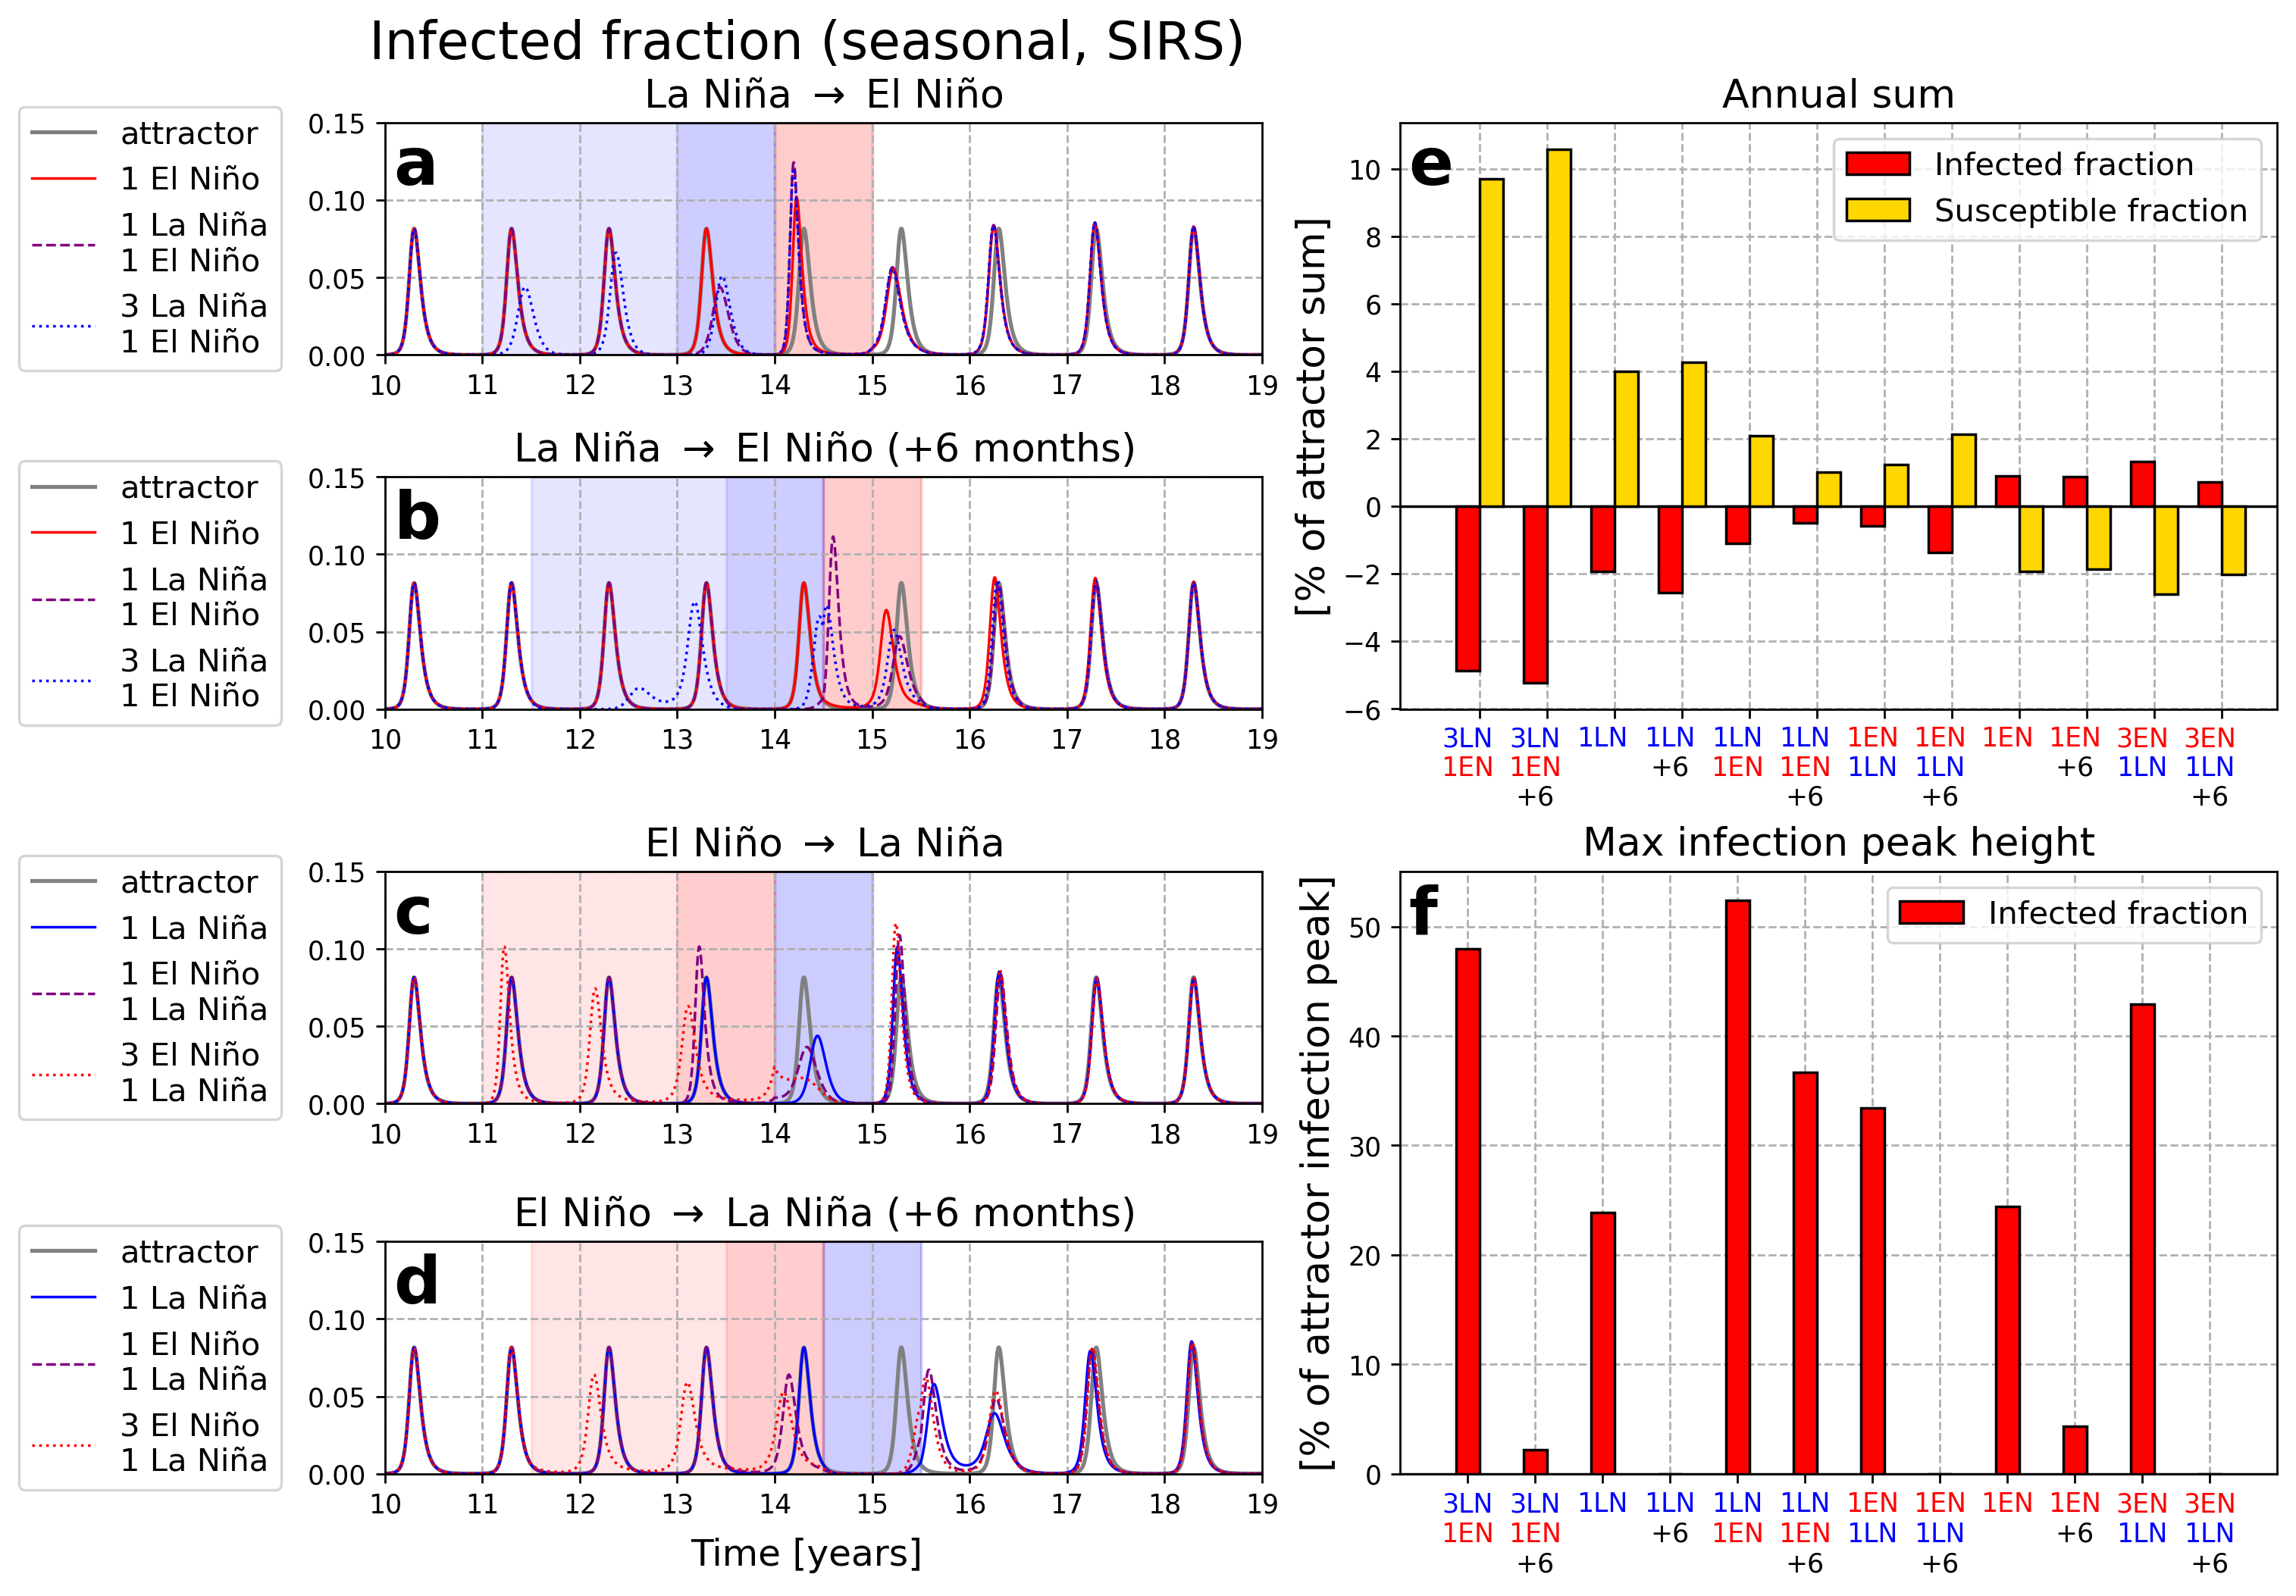

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

t_yr = ds_Nino.t/365

# Create figure and GridSpec for custom layout
fig = plt.figure(figsize=(12, 8), constrained_layout=True)
gs = GridSpec(4, 3, figure=fig, width_ratios=[1, 1, 2])

# Left side subplots (4 rows, 2 columns)
ax1 = fig.add_subplot(gs[:1, :2])
ax2 = fig.add_subplot(gs[1:2, :2], sharex=ax1)
ax3 = fig.add_subplot(gs[2:3, :2], sharex=ax1)
ax4 = fig.add_subplot(gs[3:4, :2], sharex=ax1)

# Right side subplots (2 rows, 1 column)
ax5 = fig.add_subplot(gs[:2, 2])
ax6 = fig.add_subplot(gs[2:4, 2])


###### INFECTION TIMESERIES PLOTS (A-D) ##########

# plot consecutive events
ax1.plot(t_yr,attractor.I_att,linestyle='-',color='gray',label='attractor') 
ax1.plot(t_yr,ds_Nino.ii,linestyle='-',color='red',label='1 El Niño',linewidth=1)
ax1.plot(t_yr,ds_NinaNino.ii,linestyle='--',color='purple',label='1 La Niña\n1 El Niño',linewidth=1)
ax1.plot(t_yr,ds_3Nina1Nino.ii,linestyle=':',color='b',label='3 La Niña\n1 El Niño',linewidth=1)
ax1.axvspan(14, 15, alpha=0.2, color='red')
ax1.axvspan(14-3, 14, alpha=0.1, color='b') 
ax1.axvspan(14-1, 14, alpha=0.1, color='b')
ax1.set_title(r'La Niña $\rightarrow$ El Niño',fontsize=15)

ax2.plot(t_yr,attractor.I_att,linestyle='-',color='gray',label='attractor') 
ax2.plot(t_yr,ds_Nino_6m.ii,linestyle='-',color='red',label='1 El Niño',linewidth=1)
ax2.plot(t_yr,ds_NinaNino_6m.ii,linestyle='--',color='purple',label='1 La Niña\n1 El Niño',linewidth=1)
ax2.plot(t_yr,ds_3Nina1Nino_6m.ii,linestyle=':',color='b',label='3 La Niña\n1 El Niño',linewidth=1)
ax2.axvspan(14+0.5, 15+0.5, alpha=0.2, color='red')
ax2.axvspan(14-3+0.5, 14+0.5, alpha=0.1, color='b') 
ax2.axvspan(14-1+0.5, 14+0.5, alpha=0.1, color='b')
ax2.set_title(r'La Niña $\rightarrow$ El Niño (+6 months)',fontsize=15)

ax3.plot(t_yr,attractor.I_att,linestyle='-',color='gray',label='attractor') 
ax3.plot(t_yr,ds_Nina.ii,linestyle='-',color='b',label='1 La Niña',linewidth=1)
ax3.plot(t_yr,ds_NinoNina.ii,linestyle='--',color='purple',label='1 El Niño\n1 La Niña',linewidth=1)
ax3.plot(t_yr,ds_3Nino1Nina.ii,linestyle=':',color='r',label='3 El Niño\n1 La Niña',linewidth=1)
ax3.axvspan(14, 15, alpha=0.2, color='b')
ax3.axvspan(14-3, 14, alpha=0.1, color='r') 
ax3.axvspan(14-1, 14, alpha=0.1, color='r')
ax3.set_title(r'El Niño $\rightarrow$ La Niña',fontsize=15)

ax4.plot(t_yr,attractor.I_att,linestyle='-',color='gray',label='attractor') 
ax4.plot(t_yr,ds_Nina_6m.ii,linestyle='-',color='b',label='1 La Niña',linewidth=1)
ax4.plot(t_yr,ds_NinoNina_6m.ii,linestyle='--',color='purple',label='1 El Niño\n1 La Niña',linewidth=1)
ax4.plot(t_yr,ds_3Nino1Nina_6m.ii,linestyle=':',color='r',label='3 El Niño\n1 La Niña',linewidth=1)
ax4.axvspan(14+0.5, 15+0.5, alpha=0.2, color='b')
ax4.axvspan(14-3+0.5, 14+0.5, alpha=0.1, color='r') 
ax4.axvspan(14-1+0.5, 14+0.5, alpha=0.1, color='r')
ax4.set_title(r'El Niño $\rightarrow$ La Niña (+6 months)',fontsize=15)

for axis in [ax1,ax2,ax3,ax4]:
    axis.grid(linestyle='--')
    axis.set_xlim(10,19)
    axis.set_ylim(0,0.15)
    axis.legend(fontsize=12,loc='center right', bbox_to_anchor=(-0.1, 0.5))

ax1.set_xticks(np.arange(10, 19+1, 1))

for i, ax in enumerate([ax1,ax2,ax3,ax4]):
    # Add letter annotation to upper left corner
    ax.text(0.01, 0.95, chr(97+i), transform=ax.transAxes,
            fontsize=25, fontweight='bold', va='top')
    
###### BAR PLOTS (E,F) ##########

# Width of each bar
bar_width = 0.35

# ENSO event sequences
seq = ['3LN\n1EN',
       '3LN\n1EN\n+6',
       '1LN',
       '1LN\n+6',
       '1LN\n1EN',
       '1LN\n1EN\n+6',
       '1EN\n1LN',
       '1EN\n1LN\n+6',
       '1EN',
       '1EN\n+6',
       '3EN\n1LN',
       '3EN\n1LN\n+6']
colors = ['r', 'gold']

def plot_bars(data, variable, bar_width, seq, colors, axis):
    for i, category in enumerate(variable):
        x = np.arange(len(seq)) + i * bar_width
        
        if len(variable) > 1: # for more than 1 variable (ex. infected, susceptible)
            axis.bar(x, data[i], # iterate through the variables
                      width=bar_width, 
                      label=variable[i],
                      color=colors[i], edgecolor='k', zorder=5)
        else: # for one variable only (ex. infected)
            axis.bar(x, data, # take in the one variable
                      width=bar_width, 
                      label=variable[i],
                      color=colors[i], edgecolor='k', zorder=5)

variable = ['Infected fraction', 'Susceptible fraction']
plot_bars(values_sum, variable, bar_width, seq, colors, axis=ax5)

variable = ['Infected fraction']
plot_bars(values_maxpeak, variable, bar_width, seq, colors, axis=ax6)
       
# Set the x-axis ticks without labels
ax5.set_xticks(np.arange(len(seq)) + bar_width / 2)
ax6.set_xticks(np.arange(len(seq)))

# misc.
for axis in [ax5,ax6]:
    axis.set_xticklabels([])
    axis.legend(fontsize=12, loc='upper right')
    axis.axhline(0, linewidth=1, color='k')
    axis.grid(linestyle='--')
    axis.set_xlim(-1, 12)
    
ax6.set_title(f'Max infection peak height', fontsize=15)
ax6.set_ylabel('[% of attractor infection peak]', fontsize=15)

ax5.set_title(f'Annual sum', fontsize=15)
ax5.set_ylabel('[% of attractor sum]', fontsize=15)

# Function to add colored xticklabels
def add_colored_xticklabels(ax, labels, y_offset=-0.05, fontsize=10):
    for x, label in enumerate(labels):
        parts = label.split('\n')
        y = y_offset
        
        for part in parts:
            if 'LN' in part:
                color = 'blue'
            elif 'EN' in part:
                color = 'red'
            else:
                color = 'black'
                
            ax.text(x, y, part, color=color, ha='center', va='center', fontsize=fontsize,
                    transform=ax.get_xaxis_transform())
            y -= 0.05 # y offset between the lines of the x tick labels

# Apply custom xticklabels
add_colored_xticklabels(ax5, seq)
add_colored_xticklabels(ax6, seq)

for i, axis in enumerate([ax5,ax6]):
    # Add letter annotation to upper left corner
    axis.text(0.01, 0.98, chr(101+i), transform=axis.transAxes,
            fontsize=25, fontweight='bold', va='top')

fig.supxlabel('Time [years]', x=0.35, y=0.02, ha='center', va='center', fontsize=14)
fig.suptitle('Infected fraction (seasonal, SIRS)', x=0.35, y=1, ha='center', va='bottom', fontsize=20)

# Same thing for biennial SIRS model

## load data

In [12]:
# parameters for loading the data files

D = 10 # infection period
kick = 0.75 # ENSO kick to R0
R0_base = 3 
R0_amplitude = 1.5 

In [13]:
# Load data 

# standard R0
R0_over_time = np.load(f'./SIRS_output_final/spinup_1000_R0base{R0_base}_amp{R0_amplitude}_D{D}_R0standard_biennial.npy')

# ENSO
ds_Nino = xr.open_dataset(f'./SIRS_output_final/spinup_1000_R0base{R0_base}_amp{R0_amplitude}_kick{kick}_D{D}_1Nino_biennial.nc')
ds_Nina = xr.open_dataset(f'./SIRS_output_final/spinup_1000_R0base{R0_base}_amp{R0_amplitude}_kick{kick}_D{D}_1Nina_biennial.nc')
ds_NinoNina = xr.open_dataset(f'./SIRS_output_final/spinup_1000_R0base{R0_base}_amp{R0_amplitude}_kick{kick}_D{D}_1Nino1Nina_biennial.nc')
ds_NinaNino = xr.open_dataset(f'./SIRS_output_final/spinup_1000_R0base{R0_base}_amp{R0_amplitude}_kick{kick}_D{D}_1Nina1Nino_biennial.nc')
ds_3Nino1Nina = xr.open_dataset(f'./SIRS_output_final/spinup_1000_R0base{R0_base}_amp{R0_amplitude}_kick{kick}_D{D}_3Nino1Nina_biennial.nc')
ds_3Nina1Nino = xr.open_dataset(f'./SIRS_output_final/spinup_1000_R0base{R0_base}_amp{R0_amplitude}_kick{kick}_D{D}_3Nina1Nino_biennial.nc')

In [14]:
# Load data for summer start (6 months later)

# ENSO
ds_Nino_6m = xr.open_dataset(f'./SIRS_output_final/spinup_1000_R0base{R0_base}_amp{R0_amplitude}_kick{kick}_D{D}_1Nino_biennial_summerstart.nc')
ds_Nina_6m = xr.open_dataset(f'./SIRS_output_final/spinup_1000_R0base{R0_base}_amp{R0_amplitude}_kick{kick}_D{D}_1Nina_biennial_summerstart.nc')
ds_NinoNina_6m = xr.open_dataset(f'./SIRS_output_final/spinup_1000_R0base{R0_base}_amp{R0_amplitude}_kick{kick}_D{D}_1Nino1Nina_biennial_summerstart.nc')
ds_NinaNino_6m = xr.open_dataset(f'./SIRS_output_final/spinup_1000_R0base{R0_base}_amp{R0_amplitude}_kick{kick}_D{D}_1Nina1Nino_biennial_summerstart.nc')
ds_3Nino1Nina_6m = xr.open_dataset(f'./SIRS_output_final/spinup_1000_R0base{R0_base}_amp{R0_amplitude}_kick{kick}_D{D}_3Nino1Nina_biennial_summerstart.nc')
ds_3Nina1Nino_6m = xr.open_dataset(f'./SIRS_output_final/spinup_1000_R0base{R0_base}_amp{R0_amplitude}_kick{kick}_D{D}_3Nina1Nino_biennial_summerstart.nc')

In [15]:
# Load attractor
attractor = xr.open_dataset(f'./SIRS_output_final/spinup_1000_R0base{R0_base}_amp{R0_amplitude}_D{D}_standard_attractor_biennial.nc')

# align with length of timeseries
n_t = ds_Nino.t.size
attractor = attractor.isel(t=slice(0,n_t))

## compute

In [16]:
var = ['ii','ss']
yr1, yr2 = 11, 22
ENSOyr = 14

# maxpeak in 2 parts
ii_maxpeak_1, ss_maxpeak_1 = get_proportions_maxpeak(var,attractor,
                                                     ds_3Nina1Nino,ds_3Nina1Nino_6m,
                                                     ds_Nina,ds_Nina_6m,
                                                     ds_NinaNino,ds_NinaNino_6m,
                                                    yr1,yr2)

ii_maxpeak_2, ss_maxpeak_2 = get_proportions_maxpeak(var,attractor,
                                                     ds_NinoNina,ds_NinoNina_6m,
                                                     ds_Nino,ds_Nino_6m,
                                                     ds_3Nino1Nina,ds_3Nino1Nina_6m,
                                                    yr1,yr2)

# concatenate
values_maxpeak = np.concatenate([ii_maxpeak_1,ii_maxpeak_2])

In [17]:
# peak sum in 2 parts
ii_sum_1, ss_sum_1 = get_proportions_sum(var,attractor,
                                                     ds_3Nina1Nino,ds_3Nina1Nino_6m,
                                                     ds_Nina,ds_Nina_6m,
                                                     ds_NinaNino,ds_NinaNino_6m,
                                        yr1,yr2)

ii_sum_2, ss_sum_2 = get_proportions_sum(var,attractor,
                                                     ds_NinoNina,ds_NinoNina_6m,
                                                     ds_Nino,ds_Nino_6m,
                                                     ds_3Nino1Nina,ds_3Nino1Nina_6m,
                                        yr1,yr2)

# concatenate
values_sum_ii = np.concatenate([ii_sum_1,ii_sum_2])
values_sum_ss = np.concatenate([ss_sum_1,ss_sum_2])
values_sum = np.stack([values_sum_ii,values_sum_ss])

## plot

Text(0.35, 1, 'Infected fraction (biennial, SIRS)')

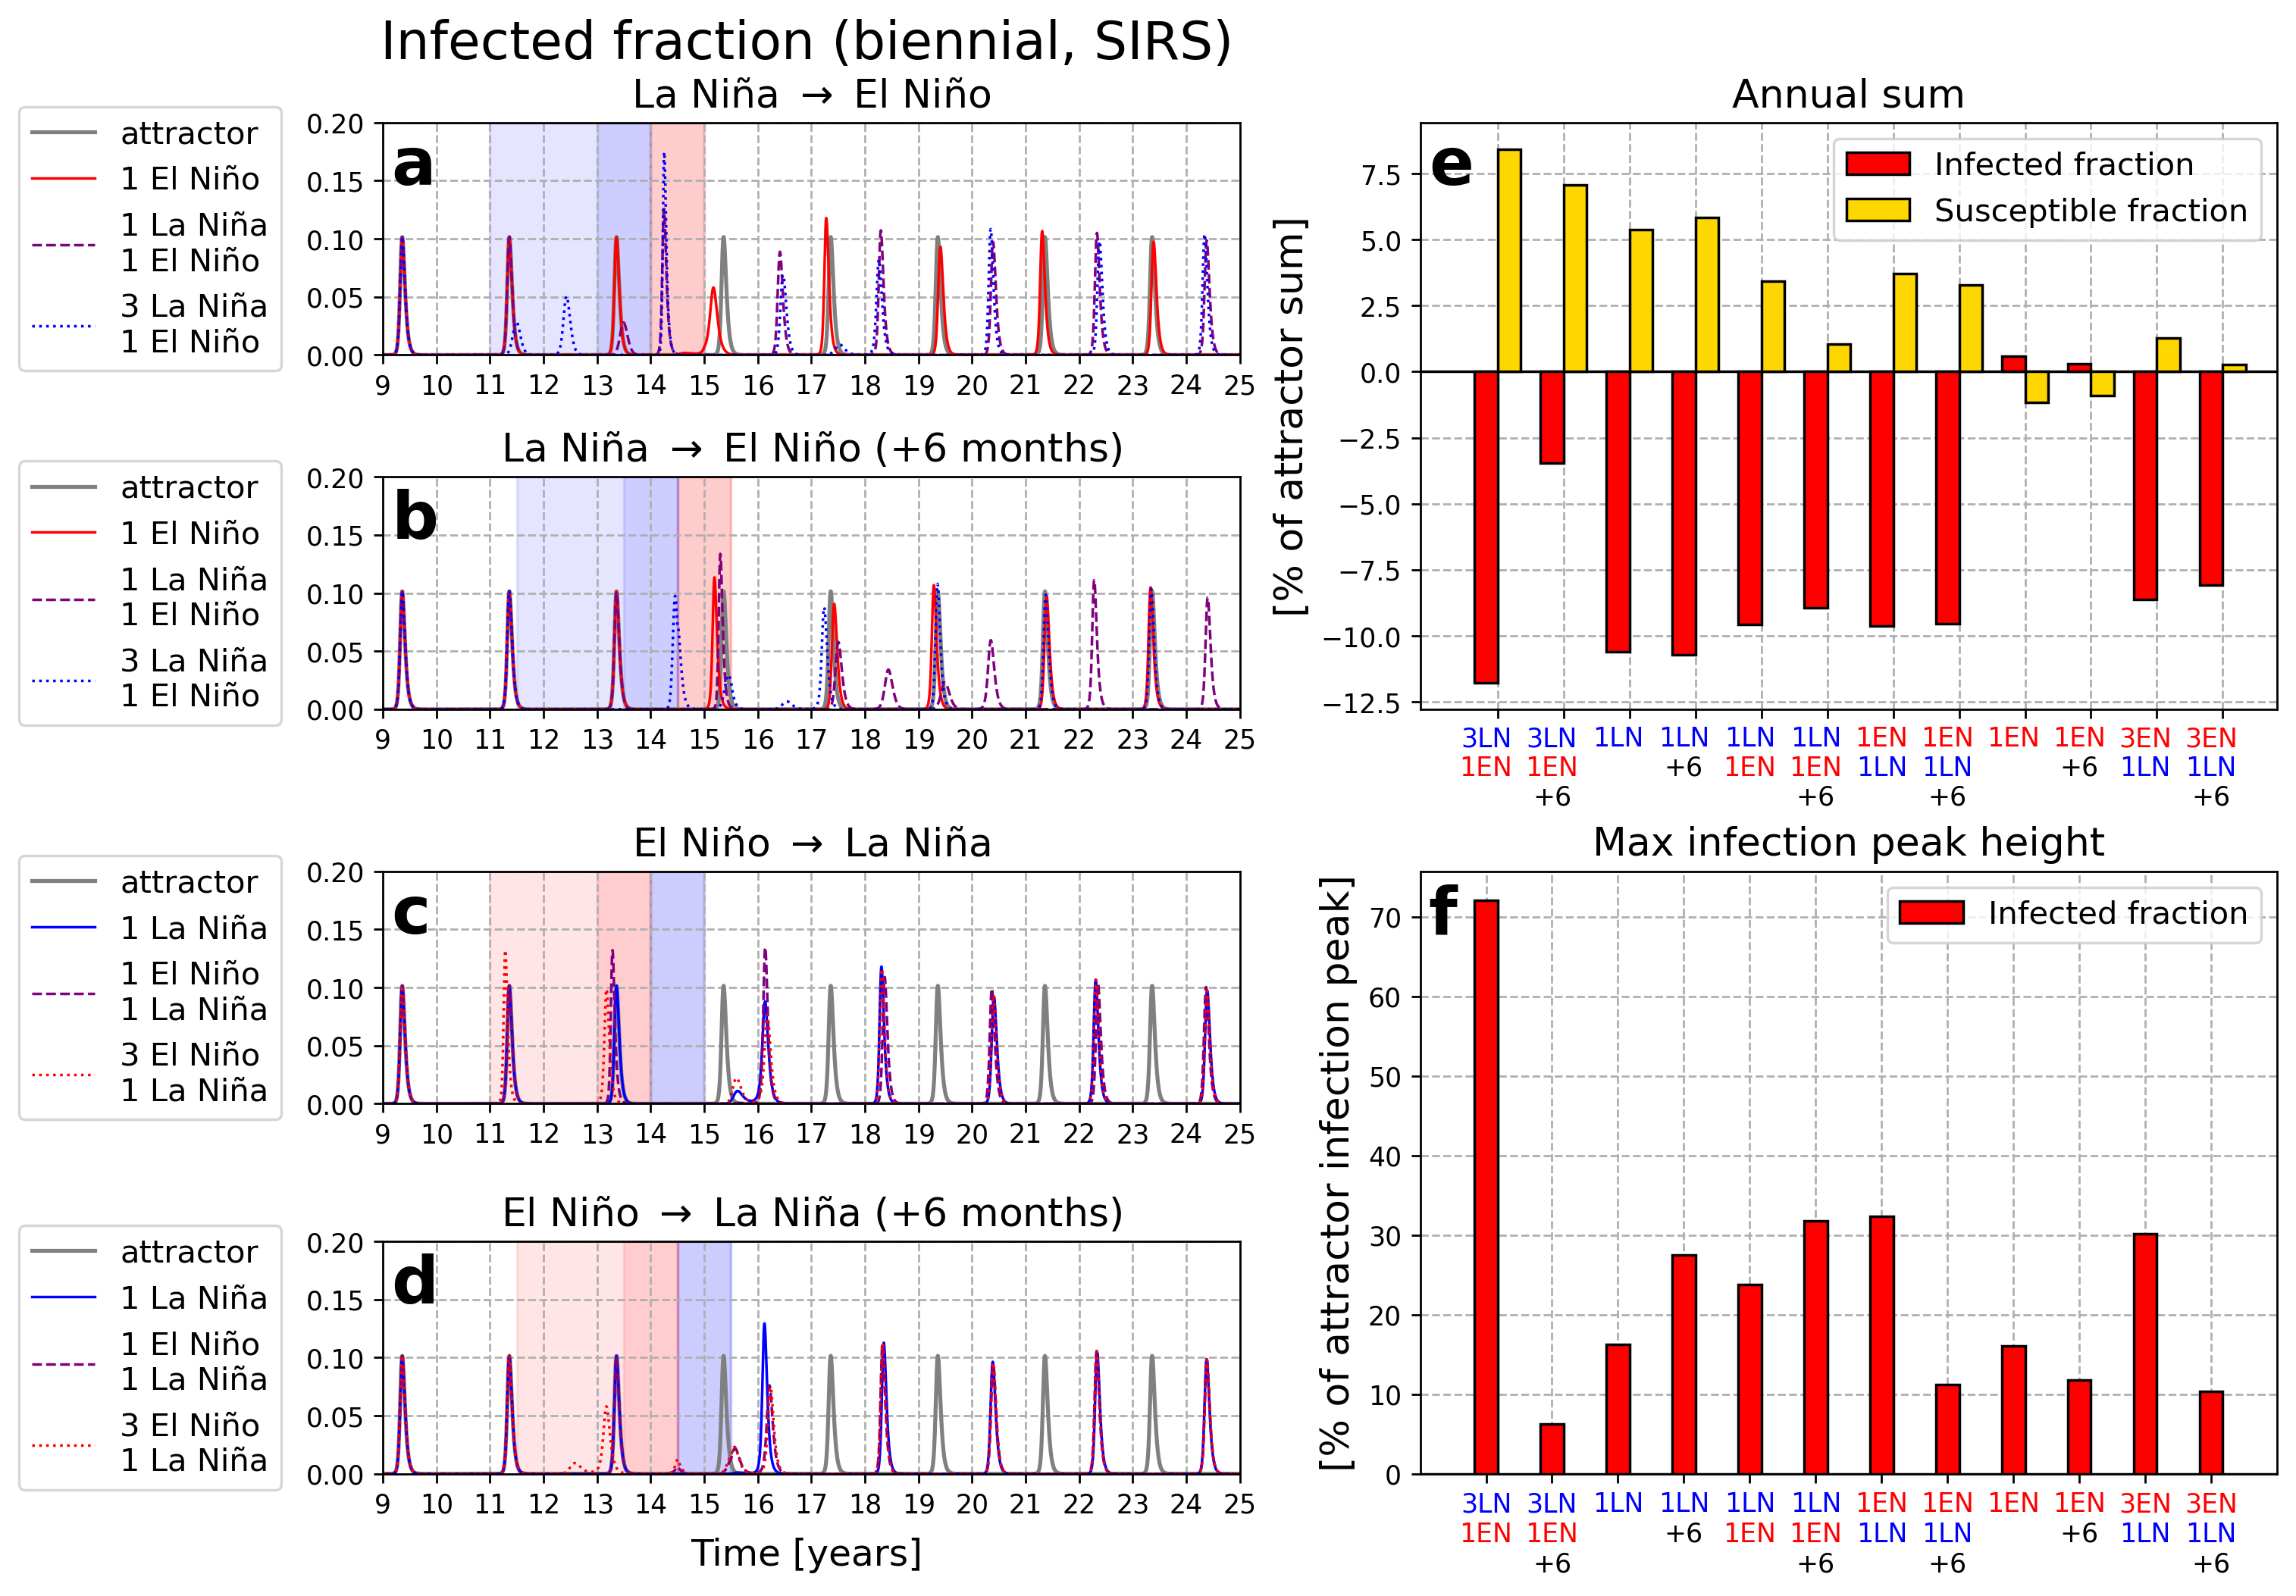

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

t_yr = ds_Nino.t/365

# Create figure and GridSpec for custom layout
fig = plt.figure(figsize=(12, 8), constrained_layout=True)
gs = GridSpec(4, 3, figure=fig, width_ratios=[1, 1, 2])

# Left side subplots (4 rows, 2 columns)
ax1 = fig.add_subplot(gs[:1, :2])
ax2 = fig.add_subplot(gs[1:2, :2], sharex=ax1)
ax3 = fig.add_subplot(gs[2:3, :2], sharex=ax1)
ax4 = fig.add_subplot(gs[3:4, :2], sharex=ax1)

# Right side subplots (2 rows, 1 column)
ax5 = fig.add_subplot(gs[:2, 2])
ax6 = fig.add_subplot(gs[2:4, 2])

###### INFECTION TIMESERIES PLOTS (A-D) ##########

# plot consecutive events
ax1.plot(t_yr,attractor.I_att,linestyle='-',color='gray',label='attractor') 
ax1.plot(t_yr,ds_Nino.ii,linestyle='-',color='red',label='1 El Niño',linewidth=1)
ax1.plot(t_yr,ds_NinaNino.ii,linestyle='--',color='purple',label='1 La Niña\n1 El Niño',linewidth=1)
ax1.plot(t_yr,ds_3Nina1Nino.ii,linestyle=':',color='b',label='3 La Niña\n1 El Niño',linewidth=1)
ax1.axvspan(ENSOyr, ENSOyr+1, alpha=0.2, color='red')
ax1.axvspan(ENSOyr-3, ENSOyr, alpha=0.1, color='b') 
ax1.axvspan(ENSOyr-1, ENSOyr, alpha=0.1, color='b')
ax1.set_title(r'La Niña $\rightarrow$ El Niño',fontsize=15)

ax2.plot(t_yr,attractor.I_att,linestyle='-',color='gray',label='attractor') 
ax2.plot(t_yr,ds_Nino_6m.ii,linestyle='-',color='red',label='1 El Niño',linewidth=1)
ax2.plot(t_yr,ds_NinaNino_6m.ii,linestyle='--',color='purple',label='1 La Niña\n1 El Niño',linewidth=1)
ax2.plot(t_yr,ds_3Nina1Nino_6m.ii,linestyle=':',color='b',label='3 La Niña\n1 El Niño',linewidth=1)
ax2.axvspan(ENSOyr+0.5, ENSOyr+1+0.5, alpha=0.2, color='red')
ax2.axvspan(ENSOyr-3+0.5, ENSOyr+0.5, alpha=0.1, color='b') 
ax2.axvspan(ENSOyr-1+0.5, ENSOyr+0.5, alpha=0.1, color='b')
ax2.set_title(r'La Niña $\rightarrow$ El Niño (+6 months)',fontsize=15)

ax3.plot(t_yr,attractor.I_att,linestyle='-',color='gray',label='attractor') 
ax3.plot(t_yr,ds_Nina.ii,linestyle='-',color='b',label='1 La Niña',linewidth=1)
ax3.plot(t_yr,ds_NinoNina.ii,linestyle='--',color='purple',label='1 El Niño\n1 La Niña',linewidth=1)
ax3.plot(t_yr,ds_3Nino1Nina.ii,linestyle=':',color='r',label='3 El Niño\n1 La Niña',linewidth=1)
ax3.axvspan(ENSOyr, ENSOyr+1, alpha=0.2, color='b')
ax3.axvspan(ENSOyr-3, ENSOyr, alpha=0.1, color='r') 
ax3.axvspan(ENSOyr-1, ENSOyr, alpha=0.1, color='r')
ax3.set_title(r'El Niño $\rightarrow$ La Niña',fontsize=15)

ax4.plot(t_yr,attractor.I_att,linestyle='-',color='gray',label='attractor') 
ax4.plot(t_yr,ds_Nina_6m.ii,linestyle='-',color='b',label='1 La Niña',linewidth=1)
ax4.plot(t_yr,ds_NinoNina_6m.ii,linestyle='--',color='purple',label='1 El Niño\n1 La Niña',linewidth=1)
ax4.plot(t_yr,ds_3Nino1Nina_6m.ii,linestyle=':',color='r',label='3 El Niño\n1 La Niña',linewidth=1)
ax4.axvspan(ENSOyr+0.5, ENSOyr+1+0.5, alpha=0.2, color='b')
ax4.axvspan(ENSOyr-3+0.5, ENSOyr+0.5, alpha=0.1, color='r') 
ax4.axvspan(ENSOyr-1+0.5, ENSOyr+0.5, alpha=0.1, color='r')
ax4.set_title(r'El Niño $\rightarrow$ La Niña (+6 months)',fontsize=15)

for axis in [ax1,ax2,ax3,ax4]:
    axis.grid(linestyle='--')
    axis.set_xlim(9,25)
    axis.set_ylim(0,0.2)
    axis.legend(fontsize=12,loc='center right', bbox_to_anchor=(-0.1, 0.5))

ax1.set_xticks(np.arange(9, 25+1, 1))

for i, ax in enumerate([ax1,ax2,ax3,ax4]):
    # Add letter annotation to upper left corner
    ax.text(0.01, 0.95, chr(97+i), transform=ax.transAxes,
            fontsize=25, fontweight='bold', va='top')
    
###### BAR PLOTS (E,F) ##########

# Width of each bar
bar_width = 0.35

# ENSO event sequences
seq = ['3LN\n1EN',
       '3LN\n1EN\n+6',
       '1LN',
       '1LN\n+6',
       '1LN\n1EN',
       '1LN\n1EN\n+6',
       '1EN\n1LN',
       '1EN\n1LN\n+6',
       '1EN',
       '1EN\n+6',
       '3EN\n1LN',
       '3EN\n1LN\n+6']
colors = ['r', 'gold']

def plot_bars(data, variable, bar_width, seq, colors, axis):
    for i, category in enumerate(variable):
        x = np.arange(len(seq)) + i * bar_width
        
        if len(variable) > 1: # for more than 1 variable (ex. infected, susceptible)
            axis.bar(x, data[i], # iterate through the variables
                      width=bar_width, 
                      label=variable[i],
                      color=colors[i], edgecolor='k', zorder=5)
        else: # for one variable only (ex. infected)
            axis.bar(x, data, # take in the one variable
                      width=bar_width, 
                      label=variable[i],
                      color=colors[i], edgecolor='k', zorder=5)

variable = ['Infected fraction', 'Susceptible fraction']
plot_bars(values_sum, variable, bar_width, seq, colors, axis=ax5)

variable = ['Infected fraction']
plot_bars(values_maxpeak, variable, bar_width, seq, colors, axis=ax6)
       
# Set the x-axis ticks without labels
ax5.set_xticks(np.arange(len(seq)) + bar_width / 2)
ax6.set_xticks(np.arange(len(seq)))

# misc.
for axis in [ax5,ax6]:
    axis.set_xticklabels([])
    axis.legend(fontsize=12, loc='upper right')
    axis.axhline(0, linewidth=1, color='k')
    axis.grid(linestyle='--')
    axis.set_xlim(-1, 12)
    
ax6.set_title(f'Max infection peak height', fontsize=15)
ax6.set_ylabel('[% of attractor infection peak]', fontsize=15)

ax5.set_title(f'Annual sum', fontsize=15)
ax5.set_ylabel('[% of attractor sum]', fontsize=15)

# Function to add colored xticklabels
def add_colored_xticklabels(ax, labels, y_offset=-0.05, fontsize=10):
    for x, label in enumerate(labels):
        parts = label.split('\n')
        y = y_offset
        
        for part in parts:
            if 'LN' in part:
                color = 'blue'
            elif 'EN' in part:
                color = 'red'
            else:
                color = 'black'
                
            ax.text(x, y, part, color=color, ha='center', va='center', fontsize=fontsize,
                    transform=ax.get_xaxis_transform())
            y -= 0.05 # y offset between the lines of the x tick labels

# Apply custom xticklabels
add_colored_xticklabels(ax5, seq)
add_colored_xticklabels(ax6, seq)

for i, axis in enumerate([ax5,ax6]):
    # Add letter annotation to upper left corner
    axis.text(0.01, 0.98, chr(101+i), transform=axis.transAxes,
            fontsize=25, fontweight='bold', va='top')

fig.supxlabel('Time [years]', x=0.35, y=0.02, ha='center', va='center', fontsize=14)
fig.suptitle('Infected fraction (biennial, SIRS)', x=0.35, y=1, ha='center', va='bottom', fontsize=20)